# How Shazam Works

<img src="https://upload.wikimedia.org/wikipedia/commons/d/d2/Shazam_logo.svg" width="60%">


Do not start the exercise until you fully understand the submission guidelines, which can be found here.

For any material-related-questions, ask Ami. For any organization-related-questions, ask Lior.


#### **Read the following instructions carefully:**
1. Write your functions in this notebook only. Do not create Python modules and import them.
Feel free to add code blocks if you need.
2. Answers to qualitative questions should be written in markdown cells (with  LATEX  support). Answers that will be written in commented code blocks will not be checked.
3. Kind reminder: the total of all exercises weight is 50% of the course's grade!

#### **This exercise summarizes the following subjects:**
1. Generate and detect a pure tone (sound generated by a sinus wave)
2. Generate and decypher a phone number dialed using a Dual tone multi-frequency (DTMF)
3. Generate a fingerprint of a song or short recording of part from a song
4. Basic demonstartion of songs identification using Shazam algorithm

#### **Data**
* Download the data (the whole directory) from [here](https://drive.google.com/drive/folders/18Sy5weuys7J1mVDRKdFUWzlL2GznbYGZ).

In [1]:
!sudo apt-get install libportaudio2
!pip install sounddevice
# All imports
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, find_peaks
from scipy.fft import fft, fftfreq
import wave
import os
import zipfile



# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Add more imports if necessary:
import random
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks
from matplotlib.ticker import MultipleLocator
import librosa
import librosa.display


'sudo' is not recognized as an internal or external command,
operable program or batch file.


## **Question 1: Generating and Identifying a Call with a Dial Tone Phone (40 Points)**

This question explores frequency analysis of sounds, specifically using FFT and spectrum analysis to understand sound.

The tasks involve generating sounds, identifying frequencies, creating a simulated tone-phone sequence, and identifying phone numbers from sound waves.

#### **1.1 Generate a Sound Based on 2 Pure Tones (10 Points)**
Generate a sound consisting of two frequencies, choosing frequencies f1 and f2 from the range [100, 3000].

Normalize the sound data so that all values fall between -1 and +1.

Plot the FFT and spectrogram.

In [2]:
sample_rate = 44100
duration_in_seconds = 3
sound_length = int(sample_rate * duration_in_seconds)
f1 = 532
f2 = 1593

def generate_tone(frequency, duration_of_tone_in_seconds = duration_in_seconds):
  wave_length = sample_rate / frequency

  return [
      np.sin((i/wave_length)*(2*np.pi))
      for i in range(int(duration_of_tone_in_seconds * sample_rate))
  ]

def _generate_two_tones_sound(freq1, freq2, duration_of_sound_in_seconds = duration_in_seconds):
    tone1 = generate_tone(freq1, duration_of_sound_in_seconds)
    tone2 = generate_tone(freq2, duration_of_sound_in_seconds)

    return np.array([(a1 + a2) / 2 for (a1, a2) in zip(tone1, tone2)])

def generate_two_tones_sound():
    '''
    Generate a sound composed of two frequencies and plot its FFT and spectrogram.
    :return: sound, the sound as a function of time
    '''
    return _generate_two_tones_sound(f1, f2)

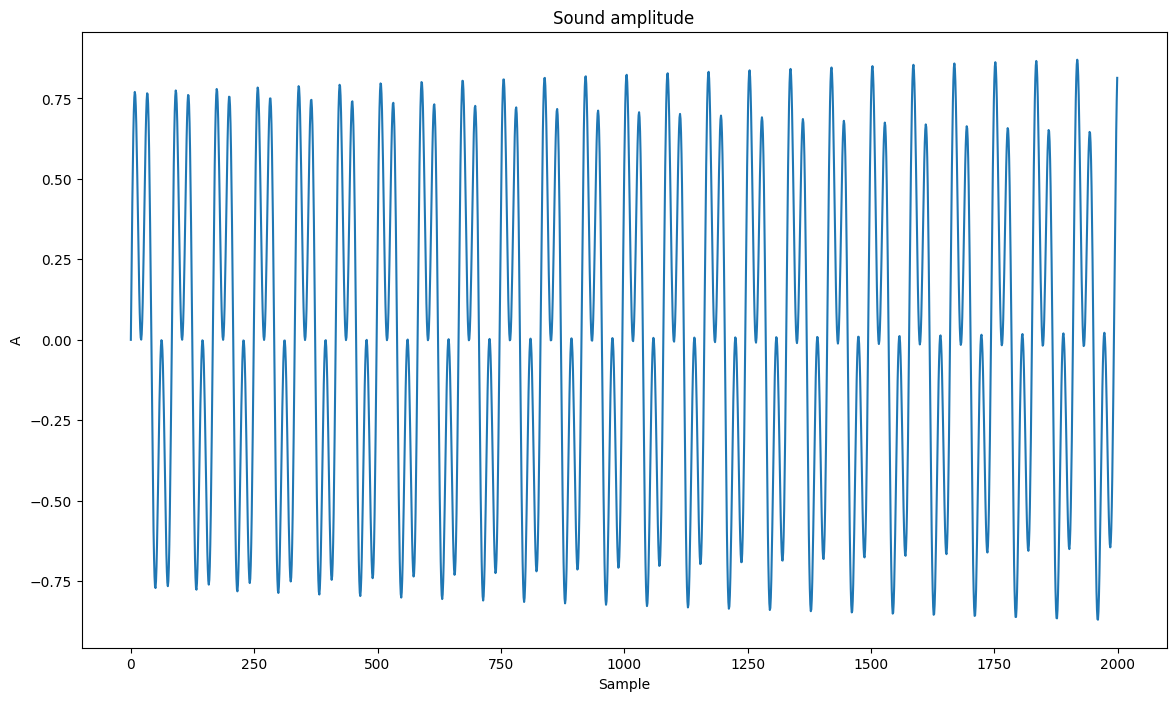

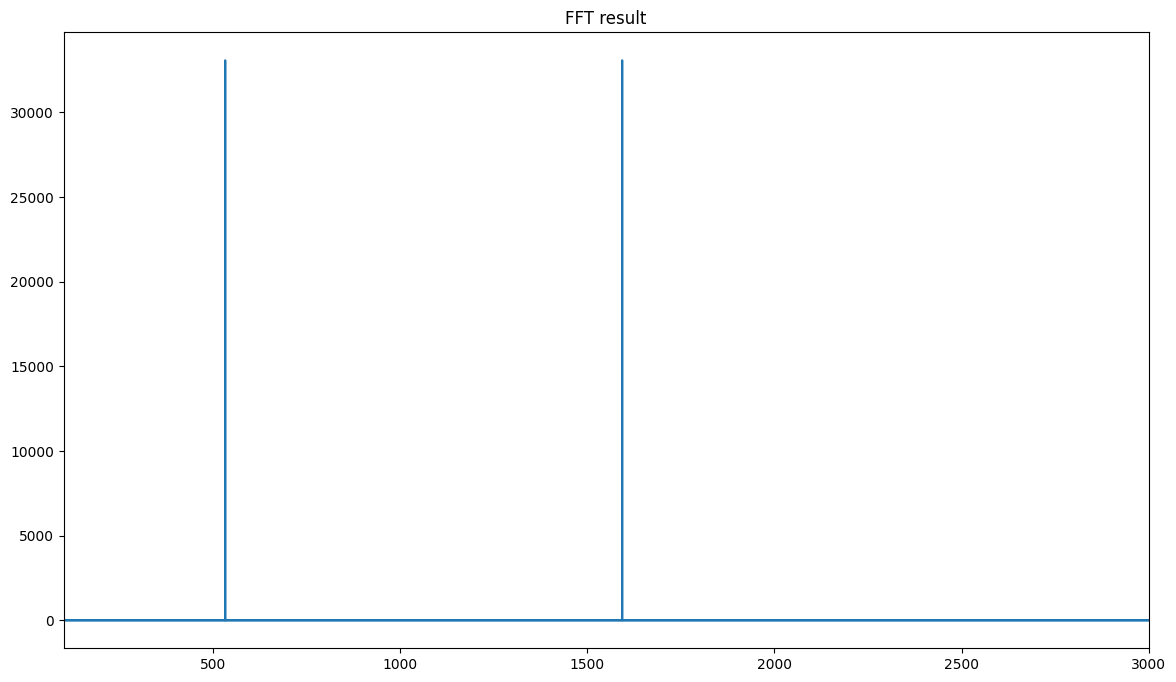

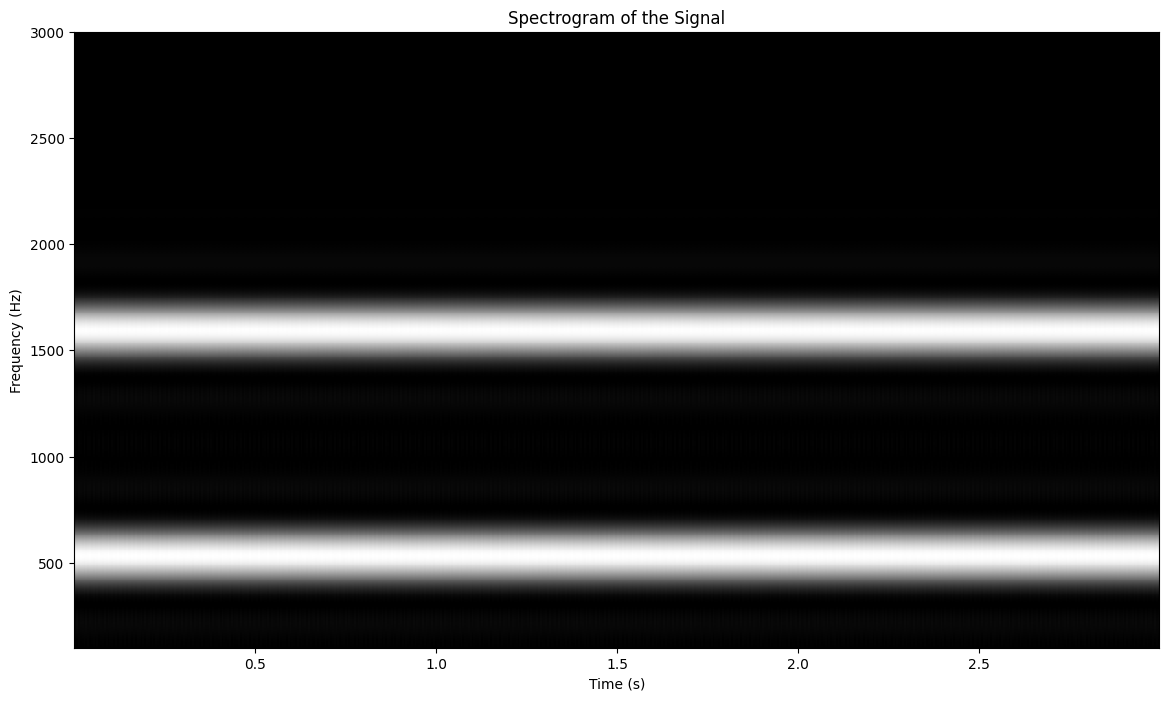

In [3]:
my_sound = generate_two_tones_sound()

samples_to_plot = 2000
plt.plot(range(samples_to_plot), my_sound[:samples_to_plot])
plt.xlabel('Sample')
plt.ylabel('A')
plt.title('Sound amplitude')
plt.show()

yf = fft(my_sound)
xf = fftfreq(sound_length, 1/sample_rate)

plt.plot(xf, np.abs(yf))
plt.xlim(100, 3000)
plt.title('FFT result')
plt.show()

f_spec, t_spec, Sxx = spectrogram(my_sound, fs=sample_rate, nfft=10000, scaling='spectrum', window=('tukey', 0.5))

plt.pcolormesh(t_spec, f_spec, Sxx)
plt.ylim(top=3000, bottom=100)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram of the Signal')
plt.show()

#### **1.2 Identify Frequencies from a Sound Signal (10 Points)**

Implement `identify_main_freq()` function to identify the main frequencies from a sound signal.



In [4]:
def identify_main_freq(sound):
    '''
    Identify the frequencies from a sound signal.

    Params:
    - sound: the sound as a function of time

    Return:
    - f1, f2: the two frequencies
    '''
    yf = np.abs(fft(sound))
    xf = fftfreq(len(sound), 1/sample_rate)


    peak_indices = find_peaks(yf, threshold=2, height=2)[0][:2]
    most_high_peaks = sorted(((a, f) for a, f in zip(yf[peak_indices], xf[peak_indices]) if f >= 0), reverse=True)

    return most_high_peaks[0][1], most_high_peaks[1][1]


In [5]:
f1,f2 = identify_main_freq(my_sound)
print('The frequencies generating the sound are: ',f1,'Hz, ',f2,'Hz')

The frequencies generating the sound are:  532.0 Hz,  1593.0 Hz


#### **1.3 Generate the Sound of a Tone Phone for a 10-Digit Call (10 Points)**

In this section, you will generate a sound consisting of 10 digits dialed from a "tone-phone" as exaplined in class and with the help of the python code presented in class.

Generate a sound of dialing a 10-digit number such as 054 257 8620 using a tone-phone.

Use your mobile number.

In [6]:
phone_number = '0547871732'

In [7]:
digit_to_freq_pair = {
    '1': (697, 1209),
    '2': (697, 1336),
    '3': (697, 1477),
    '4': (770, 1209),
    '5': (770, 1336),
    '6': (770, 1477),
    '7': (852, 1209),
    '8': (852, 1336),
    '9': (852, 1477),
    '0': (941, 1336),
}

def generate_sound(phone_number: str):
    '''
    Generates a sound simulating the dialing of a 10-digit phone number using a tone-phone.
    Params:
    - phone_number: the phone number to dial (e.g., '0542986725')

    Return:
    - sound as an array
    '''
    frequency_pairs = (digit_to_freq_pair[digit] for digit in phone_number)
    digit_sounds = (_generate_two_tones_sound(f1, f2, 0.5) for f1, f2 in frequency_pairs)

    return np.array([a for digit_sound in digit_sounds for a in digit_sound])

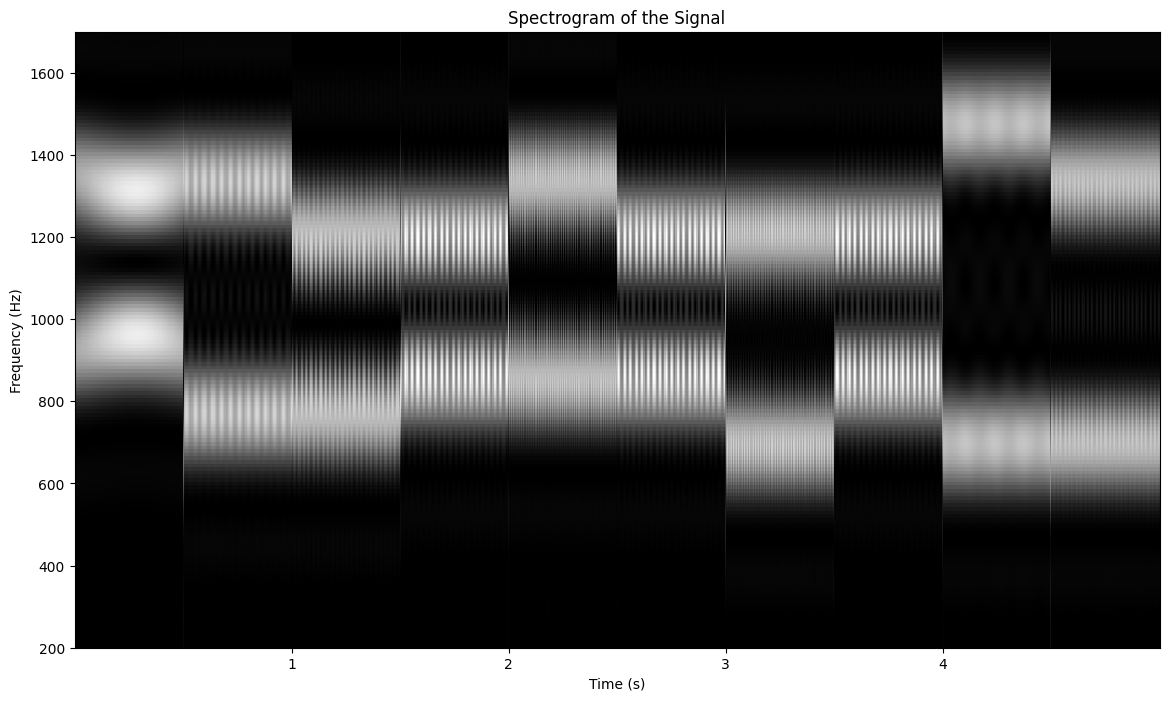

In [8]:
sound = generate_sound(phone_number)

f_spec_phone, t_spec_phone, Sxx_phone = spectrogram(sound, fs=sample_rate, nfft=5000, scaling='spectrum', window=('tukey', 0.5))

plt.pcolormesh(t_spec_phone, f_spec_phone, Sxx_phone)
plt.ylim(top=1700, bottom=200)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram of the Signal')
plt.show()

#### **1.4 Identify a Phone Number from a Sound Wave (10 Points)**
Identify the 10 digits dialed using frequency analysis of sound.

In [9]:
def _find_closest_digit(f1, f2):
  return min((euclidean((f1, f2), freq_pair), digit)for digit, freq_pair in digit_to_freq_pair.items())[1]

def identify_phone_number(sound):
    '''
    Idenfities the 10 digits from a sound and return them.
    Params:
    - sound: sound as an array

    Return:
    - phone_number: a string with the digits dialed such as '0542578620'
    '''
    digit_sounds = np.array_split(sound, 10)
    frequency_pairs = (identify_main_freq(digit_sound) for digit_sound in digit_sounds)

    return "".join(_find_closest_digit(min(f1, f2), max(f1, f2)) for (f1, f2) in frequency_pairs)

In [10]:
identified_number = identify_phone_number(sound)
print(f'The phone number dialed was: {identified_number}, expected: {phone_number}')

The phone number dialed was: 0547871732, expected: 0547871732


## **Question 2: How Shazam Algorithm Works (60 Points)**
This question explores the Shazam algorithm, focusing on creating a fingerprint for a set of songs and then identifying a short sample from one of the songs in a potentially noisy environment.

The process involves creating a spectrogram, generating fingerprints, and matching them against a database of known songs.

#### **2.1 Create Simplified Spectrogram (10 Points)**
Generate a simplified spectrogram based on the actual spectrogram of the sound. The simplifications include maintaining a single column of data per 0.1 sec in the time axis and retaining the maximum value from the original spectrogram in each frequency range.

Write `create_simplified_spectrogram()` function, which takes audio data and returns a simplified spectrogram based on the actual spectrogram of the sound.

1. In the time axis, keep a single column of data per 0.1 sec, retaining the max value from the original spectrogram.
2. In the frequency axis, divide the total frequency range into 6 ranges, and keep only 6 values per 0.1 sec window - one for each range.

In [11]:
def create_simplified_spectrogram(audio_data, vis = False):
    num_freq = 6
    time_interval = int(sample_rate/10)
    f_spec, t_spec, Sxx = spectrogram(audio_data, sample_rate, nperseg=time_interval)
    simple_spectrogram = []
    for time_idx, window in enumerate(Sxx.T):
        all_peaks, properties = find_peaks(abs(window), prominence=0, distance=50)
        num_peaks_in_time_idx = min(num_freq, len(all_peaks))
        strongest_peaks_indices = np.argpartition(properties["prominences"], -num_peaks_in_time_idx)[-num_peaks_in_time_idx:]
        strongest_peaks = all_peaks[strongest_peaks_indices]
        for peak in strongest_peaks:
            peak_freq = f_spec[peak]
            simple_spectrogram.append([time_idx, peak_freq])

    if vis:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.pcolormesh(t_spec, f_spec, 10 * np.log10(Sxx), shading='auto')
        plt.title('Spectrogram')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.ylim(top=2000)

        plt.ylim(bottom=0)
        plt.subplot(1, 2, 2)
        simple_spectrogram = np.array(simple_spectrogram)
        plt.scatter(simple_spectrogram[:, 0] * t_spec[1], simple_spectrogram[:, 1], c='r', s=1)
        plt.title('Simplified Spectrogram')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.ylim(top=2000)
        plt.ylim(bottom=0)
        plt.show()



    return np.array(simple_spectrogram)

In [12]:
sound_file_path = 'data/songs/Despacito.wav'
audio_data, sample_rate_1 = librosa.load(sound_file_path)
test_simple_spectrogram =  create_simplified_spectrogram(audio_data)

print("test_simple_spectrogram.shape: ", test_simple_spectrogram.shape)

test_simple_spectrogram.shape:  (9384, 2)


In [13]:
sound_file_path = 'data/samples/D2.wav'
audio_data, sample_rate_1 = librosa.load(sound_file_path)
test_simple_spectrogram_rec =  create_simplified_spectrogram(audio_data)
print("test_simple_spectrogram_rec.shape: ", test_simple_spectrogram_rec.shape)

test_simple_spectrogram_rec.shape:  (168, 2)


In [14]:
sound_file_path = 'data/samples/B1.wav'
audio_data, sample_rate_1 = librosa.load(sound_file_path)
test_simple_spectrogram_rec_2 =  create_simplified_spectrogram(audio_data)
print("test_simple_spectrogram_rec.shape: ", test_simple_spectrogram_rec.shape)

test_simple_spectrogram_rec.shape:  (168, 2)


#### **2.2 Create Fingerprint (10 Points)**
Create a fingerprint from a simple spectrogram, generating a dictionary with elements in the format {(fa, fx, dt): (time, source_name)}.

* `fa` is the frequency of the anchor point.
* `fx` is the frequency of a point after in the frame area.
* `dt` is the time passed between the anchor sound and the x sound in the frame
* `time` is the time of the original anchor.

**Note:** Please see the lecture noted on the Shazam algorithm for comprehensive explanation


In [15]:
def create_fingerprint(source_name: str, simple_spectrogram) -> list:
    '''
    Get a simple_spectrogram and return its fingerprint.

    Params:
    - source_name: the name of the song or sample this data comes from (examples: 'despacito', 'recording#5')
    - simple_spectrogram: simple_spectrogram of the data

    Return:
    - fingerprint_dict: a dictionary of the fingerprints of the data
    '''
    fingerprint_dict = {}
    window = 20
    for anchor, (anchor_t, anchor_freq) in enumerate(simple_spectrogram):
        for pt_t, pt_freq in simple_spectrogram[anchor:anchor+300]:
            diff = pt_t - anchor_t
            if diff > 0 and diff < window:
                fingerprint_dict[(anchor_freq, pt_freq, diff)] = (anchor_t, source_name)

    print("found ", len(fingerprint_dict), " fingerprints for source_name: ", source_name)
    return fingerprint_dict

In [16]:
print(test_simple_spectrogram.shape)
print(test_simple_spectrogram_rec.shape)
print(test_simple_spectrogram_rec_2.shape)
fingerprints_test = create_fingerprint('despasito', test_simple_spectrogram)
fingerprints_test_rec = create_fingerprint('D2', test_simple_spectrogram_rec)
fingerprints_test_rec_2 = create_fingerprint('G3', test_simple_spectrogram_rec_2)

(9384, 2)
(168, 2)
(186, 2)


found  759869  fingerprints for source_name:  despasito
found  11960  fingerprints for source_name:  D2
found  14136  fingerprints for source_name:  G3


#### **2.3 Fingerprints Match Score (10 Points)**
Compare two fingerprints to determine if they match.

Return a real number between 0 and 1, where 0 signifies no similarity found, and 1 indicates full similarity.

In [17]:
def fingerprints_match_score(fingerprint_rec, fingerprint_db) -> float:
    '''
    Compare two fingerprints to see if they match.
    Params:
    - fingerprint1: fingerprint of a song
    - fingerprint2: fingerprint of a recorded sample

    Returns:
    - match_score: a real number between 0 and 1.
    '''
    match_score = 0

    for key1 in fingerprint_rec:
        if key1 in fingerprint_db:
            match_score += 1

    # print("match_score: ", match_score, "  len(fingerprint_rec): ", len(fingerprint_rec), "  len(fingerprint_db): ", len(fingerprint_db))
    return match_score / len(fingerprint_rec)

print("comparison of despasito and D2: ", fingerprints_match_score(fingerprints_test_rec, fingerprints_test))
print("comparison of despasito and G3: ", fingerprints_match_score(fingerprints_test_rec_2, fingerprints_test))

comparison of despasito and D2:  0.3779264214046823
comparison of despasito and G3:  0.11297396717600452


#### **2.4 Create a Database (15 Points)**
Create a database of fingerprints from a directory of songs.

Each song generates here a list of elements in the format: `[song_name, fa, fx, dt]`.

In [18]:
def create_database(songs_dir: str):
    '''
    Creates a database of fingerprints from a directory of songs.
    Each song generates here a dict of elements in the format: {song_name: {fingerprints of that song}}

    Params:
    - songs_dir: path to songs' directory.

    Return:
    - database: a database consisting of all the songs' fingerprints.
    '''

    database = {}
    for filename in os.listdir(songs_dir):
      if filename.endswith(".wav"):
        audio_data, _ = librosa.load(os.path.join(songs_dir, filename))
        fingerprints = create_fingerprint(filename, create_simplified_spectrogram(audio_data))
        database[filename] = fingerprints
    return database

In [19]:
database = create_database('data/songs')

found  520846  fingerprints for source_name:  Bad Habits - ed sheeran.wav
found  759869  fingerprints for source_name:  Despacito.wav
found  594750  fingerprints for source_name:  Go - Cat Burns.wav


#### **2.5 Identify a Sample Recording in the Songs Database (15 Points)**
Identify a user's short recording by comparing its fingerprint against the fingerprints of all songs in the application database.

The process involves creating a fingerprint for the user's recording and looking for the best match in the database.

Follow these steps:
1. Create a fingerprint of the User's short recording
2. Compare it to the fingerprints of all the songs in the application database
3. Return the name of the song with the best match score or return "no song identified" if the best match score seems to be too low.

##### **2.5.1 Identify Sample (5 Points)**
Takes a list of fingerprints of a sample sound and attempts to find a match in a database.

Returns the name of the song if found or None if no match is identified.

In [20]:
def identify_sample(sample_fingerprints, database):
    '''
    Takes list of fingerprints of a sample sound and tries to find a match in a database.

    Params:
    - sample_fingerprints: fingerprints of the sample the user recorded
    - database: the database with all the known songs, and their fingerprints

    Return:
    - song: If a song was found, return its name, otherwise return None.
    '''
    # print("sample_fingerprints: ", list(sample_fingerprints.keys())[0])
    matches = {}
    for song_name, fps_dict in database.items():
        # print("matching with song: ", song_name)
        matches[song_name] = fingerprints_match_score(sample_fingerprints, fps_dict)
    return matches

In [21]:
def get_max_match(matches, threshold=0.1):
    results = {}
    for song, song_matches in matches.items():
        best_match = max(song_matches, key=song_matches.get)
        if song_matches[best_match] >= threshold:
            results[song] = (best_match, song_matches[best_match])
        else:
            results[song] = None
    return results

##### **2.5.2 Read Samples and Identify Matches (5 Points)**
Read samples from the data/samples directory, generate fingerprints, and identify matches in the database.

In [22]:
def prepare_fingerprints_from_sample_file(sample_file):
    # Load audio data and get simplified spectrogram
    audio_data, _ = librosa.load(sample_file)
    simple_spectrogram = create_simplified_spectrogram(audio_data)

    # Create fingerprint for the sample
    fingerprint_test_sample = create_fingerprint(sample_file, simple_spectrogram)

    return fingerprint_test_sample

In [23]:
def scan_samples_dir():
    # Directory containing sample files
    samples_directory = 'data/samples/'

    # List all files in the directory
    sample_files = os.listdir(samples_directory)

    matches = {}

    # Iterate over each sample file
    for sample_file in sample_files:
        # Construct full path to the sample file
        sample_path = os.path.join(samples_directory, sample_file)
        fingerprint_test_sample = prepare_fingerprints_from_sample_file(sample_path)
        # Match the fingerprint against the database
        match = identify_sample(fingerprint_test_sample, database)
        # Add match to results dict
        matches[sample_file] = match

    return matches

In [24]:
# generate db and scan samples
matches = scan_samples_dir()

found  14136  fingerprints for source_name:  data/samples/B1.wav
found  5044  fingerprints for source_name:  data/samples/B2.wav
found  8390  fingerprints for source_name:  data/samples/B3.wav
found  11570  fingerprints for source_name:  data/samples/D1.wav


found  11960  fingerprints for source_name:  data/samples/D2.wav
found  18243  fingerprints for source_name:  data/samples/D3.wav
found  33296  fingerprints for source_name:  data/samples/D4.wav
found  10155  fingerprints for source_name:  data/samples/G1.wav
found  7896  fingerprints for source_name:  data/samples/G2.wav
found  11400  fingerprints for source_name:  data/samples/G3.wav
found  13579  fingerprints for source_name:  data/samples/X1.wav
found  8773  fingerprints for source_name:  data/samples/X2.wav
found  17581  fingerprints for source_name:  data/samples/X3.wav


##### **2.5.3 Evaluate the Matches (5 Points)**
Print the sample names and matched songs or inform that none was found.

In [25]:
# get max match by threshold
results = get_max_match(matches, 0.25)
dict(sorted(results.items()))

{'B1.wav': ('Bad Habits - ed sheeran.wav', 1.0),
 'B2.wav': ('Bad Habits - ed sheeran.wav', 0.6810071371927042),
 'B3.wav': ('Bad Habits - ed sheeran.wav', 0.865673420738975),
 'D1.wav': ('Despacito.wav', 0.26525496974935175),
 'D2.wav': ('Despacito.wav', 0.3779264214046823),
 'D3.wav': ('Despacito.wav', 0.437099161322151),
 'D4.wav': ('Despacito.wav', 0.4332051898125901),
 'G1.wav': ('Go - Cat Burns.wav', 1.0),
 'G2.wav': ('Go - Cat Burns.wav', 0.5279888551165147),
 'G3.wav': ('Go - Cat Burns.wav', 0.8067543859649123),
 'X1.wav': None,
 'X2.wav': None,
 'X3.wav': None}